# Description

In this notebook, the main objective is to generate new useful features, select important features for the model, and explain the model results. For the first part, I have created different functions to analyse the features such as binning the numerical features and analysing the degree of class seperation with respect to bins of each numerical features. I have also generated functions to create product, ratio, and difference features using pair of existing features, and analysed them using similar methods. Later, I preprocess data by encoding categorical features and handling missing values. For feature selection, I implemented simple ensemble model and used the permutation feature importance to determine the best and secondary features for the model building. I have further used SHAP module for local and global model explainibility methods to see which features contribute more to false negatives and false positive predictions, as well as individual sample default predictions. In the last step, I have tuned the ensemble tree model using Optuna auto-tune module and predicted the credit default for the test data with the final tuned model. The notebook covers the following steps


1.   **Loading modules and data**
2.  **Feature Engineering and preprocessing**
3.   **Feature Selection**
4.   **Model explainability**
5.   **Probabilistic Auto-Tuning with Optuna and Default prediction with LightGBM module**

The feature engineering steps of the notebook below may be confusing, because I have summarized the feature engineering on top of the actual analysis. 

# Importing Modules and loading data from Kaggle

In [ ]:
# !pip install dask[complete]
# ! pip install kaggle
# ! mkdir ~/.kaggle
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# ! kaggle competitions download -c amex-default-prediction
# ! unzip 'amex-default-prediction.zip'

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import dask.dataframe as dd
import pandas as pd

### Load Test Data

In [ ]:
# ! kaggle competitions download -c amex-default-prediction -f test_data.csv
# ! unzip 'test_data.csv.zip'

test_data.csv.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  test_data.csv.zip
replace test_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

### Load Train Data

In [ ]:
# ! kaggle competitions download -c amex-default-prediction -f train_labels.csv
# ! unzip 'train_labels.csv.zip'
# ! kaggle competitions download -c amex-default-prediction -f train_data.csv
# ! unzip 'train_data.csv.zip'


In [ ]:
# If you want to use 
# merge data and labes to a single dataframe
train_data = dd.read_csv("train_data.csv", storage_options={'anon': True}, assume_missing=True)
train_labels=dd.read_csv("train_labels.csv", storage_options={'anon': True}, assume_missing=True)
join=train_data.merge(train_labels,how='left',on=['customer_ID'])

In [ ]:
# convert dask dataframe to parquet data and save as pickle object for later use
join.to_parquet('train_parquet2/')
train_parquet_path = 'train_parquet2'
train_parquet = pd.read_parquet(train_parquet_path).groupby('customer_ID').tail(2).set_index('customer_ID',drop=True).sort_index() # select last two months
# train_parquet.to_pickle('train_last_2.pkl')

In [ ]:
train_parquet.shape

(912706, 190)

# Feature engineer

## Summary

The following blocks of codes are the summary of the first attempt on the feature engineering section.

In [ ]:
# These features has been found based on permutation
# feature importances using a simple tree model (not included here)
best_numeric=['B_9','B_8','B_4','B_3','B_2','B_1','B_40', 'B_16', 'B_28', 'B_25','B_15', 'B_6',
 'D_75', 'D_60','D_42','D_45', 'D_53','D_43', 'D_48', 'D_44', 'D_46','D_50','D_47', 
 'D_41', 'D_71', 'D_52', 'D_51', 'D_121', 'D_132', 'D_39', 'D_59', 'D_76', 'S_22', 
 'R_3', 'R_27', 'R_1','R_2', 'S_24', 'S_3', 'S_5','S_6', 'S_25', 'S_13', 'S_23', 'R_9', 'S_9',
 'S_26', 'S_8', 'R_12', 'R_26', 'S_6', 'S_7', 'S_12', 'S_27', 'P_2', 'P_3', 'P_4']

best_cat= ['B_31','B_30','B_38', 'D_63','D_64','D_66',
           'D_68','D_87','D_114','D_116','D_117','D_120','D_126']
          
best=best_numeric+best_cat

# secondary but not worst features
not_best=['D_61', 'D_112', 'B_11', 'D_55', 'B_5', 'S_15', 'D_56', 'B_37',
          'D_62', 'B_20', 'D_58', 'D_77', 'B_14', 'D_128', 'D_74', 'B_18',
          'D_129', 'D_72', 'D_91', 'D_54', 'D_49', 'D_102', 'R_16', 'R_10',
          'D_127', 'D_78', 'B_22', 'B_10', 'S_11', 'R_6', 'B_17', 'B_7',
          'D_122', 'D_70', 'D_115']

In [ ]:
# To see the effect of a numerical variable on the binary variable,
# we will bin the variable based on the percentile values, and then 
# check the empirical probability of default for different intervals of variable values.
def bin_numerical_cols(df, numerical_cols, drop=True,number_of_bins=40):
    '''
    Create bins for numerical variables based on quantiles
    
    Inputs:
        data:  Cleaned and feature engineered SBA dataframe
        drop:  True or False/ True drops binned numerical columns
        number_of_bins: Maximum number of quantile bins
    
    Output: Dataframe with bin columns
    '''
    #This can also be done with if condition to determine numerical columns
    from copy import deepcopy
    data=deepcopy(df)
    bin_columns=[]
    binned_col=[]
    bins_for_cols={}
    for col in numerical_cols:
        vals=data[~data[col].isna()][col].values
        bins=[np.percentile(vals,i) for i in np.linspace(2.5,97.5,number_of_bins-1)]
        bins=np.concatenate([[-np.inf],bins,[np.inf]])
        bins_for_cols[col]=bins
        data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop').astype('object')
        data[col+'_bin'].fillna('missing',inplace=True)
        #data[col+'_bin']=data[col+'_bin'].astype('object')
        # data[col+'_bin']=pd.cut(data[col], bins,duplicates='drop').astype('object')
        binned_col.append(col)
        bin_columns.append(col+'_bin')
    if drop==True:
        data.drop(columns=binned_col,inplace=True)
    return data,bin_columns, bins_for_cols
    
train_parquet,bin_cols,jjj=bin_numerical_cols(train_parquet, bin_cols, drop=True,number_of_bins=11)
train_parquet[bin_cols]

,R_4_bin,B_12_bin,B_13_bin,R_5_bin,D_65_bin,B_19_bin,B_21_bin,D_69_bin,B_23_bin,D_73_bin,...,D_136_bin,D_137_bin,D_138_bin,D_139_bin,D_140_bin,D_141_bin,D_142_bin,D_143_bin,D_144_bin,D_145_bin
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,"(0.00357, 0.00468]","(0.0716, 0.145]","(0.0576, 0.0941]","(0.00249, 0.0036]","(0.00938, 0.717]","(0.00641, 0.00793]","(0.00241, 0.00349]","(0.00681, 0.00791]","(0.0268, 0.0477]",missing,...,missing,missing,missing,"(0.000305, 0.00159]","(0.00133, 0.00242]","(0.00158, 0.00286]",missing,"(0.000304, 0.00158]","(0.00608, 0.00724]","(0.00415, 0.00543]"
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,"(0.00801, 0.00911]","(0.0716, 0.145]","(0.0941, 0.169]","(0.00914, 0.509]","(0.00824, 0.00938]","(0.0049, 0.00641]","(0.00457, 0.00565]","(0.00462, 0.00572]","(0.0268, 0.0477]",missing,...,missing,missing,missing,"(0.00672, 0.00799]","(0.00349, 0.00458]","(0.00414, 0.00541]",missing,"(0.00543, 0.0067]","(0.0026, 0.00376]","(0.00798, 0.00927]"
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,"(0.000262, 0.00136]","(0.015, 0.0236]","(0.00555, 0.0088]","(0.00249, 0.0036]","(0.000267, 0.00141]","(0.00186, 0.00338]","(0.00781, 0.00889]","(0.00572, 0.00681]","(0.0101, 0.0171]",missing,...,missing,missing,missing,"(0.00543, 0.00672]","(0.00458, 0.00566]","(0.00414, 0.00541]",missing,"(0.00798, 0.00926]","(0.00143, 0.0026]","(0.00287, 0.00415]"
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,"(0.00247, 0.00357]","(0.015, 0.0236]","(0.0134, 0.0223]","(0.00582, 0.00692]","(0.00824, 0.00938]","(0.00793, 0.00944]","(0.00565, 0.00673]","(0.00681, 0.00791]","(0.0101, 0.0171]",missing,...,missing,missing,missing,"(0.00288, 0.00416]","(0.00674, 0.00782]","(0.0067, 0.00798]",missing,"(0.00286, 0.00414]","(0.0026, 0.00376]","(0.00798, 0.00927]"
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,"(0.00136, 0.00247]","(0.00555, 0.00806]","(0.00138, 0.00555]","(0.00803, 0.00914]","(0.00482, 0.00596]","(0.00186, 0.00338]","(0.00673, 0.00781]","(0.000256, 0.00135]","(0.0268, 0.0477]",missing,...,missing,missing,missing,"(0.00799, 0.00927]","(0.00891, 0.00999]","(0.00286, 0.00414]",missing,"(0.00414, 0.00543]","(0.00724, 0.00841]","(0.00543, 0.00671]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
ffff9984b999fccb2b6127635ed0736dda94e544e67e026eee4d20f680639ff6,"(0.00911, 1.005]","(0.0396, 0.0716]","(0.0359, 0.0576]","(0.00582, 0.00692]","(0.00369, 0.00482]","(0.00186, 0.00338]","(0.00457, 0.00565]","(0.000256, 0.00135]","(0.0268, 0.0477]",missing,...,missing,missing,missing,"(0.00543, 0.00672]","(0.00242, 0.00349]","(0.00158, 0.00286]",missing,"(0.00798, 0.00926]","(0.000274, 0.00143]","(0.00158, 0.00287]"
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461,"(0.00578, 0.00689]","(0.00555, 0.00806]","(0.00555, 0.0088]","(0.00803, 0.00914]","(0.00255, 0.00369]","(0.00338, 0.0049]","(0.00565, 0.00673]","(0.00353, 0.00462]","(0.297, 0.481]",missing,...,missing,missing,missing,"(1.003, 1.009]","(0.00458, 0.00566]","(0.879, 0.983]","(0.424, 0.509]","(0.00926, 1.003]","(0.00376, 0.00492]","(0.0976, 0.645]"
ffffa5c46bc8de74f5a4554e74e239c8dee6b9baf388145b2c3d01967fcce461,"(0.00689, 0.00801]","(0.00806, 0.0103]","(0.00555, 0.0088]","(0.000262, 0.00138]","(0.00482, 0.00596]","(0.00793, 0.00944]","(0.00457, 0.00565]","(0.009, 0.145]","(0.176, 0.297]",missing,...,missing,missing,missing,"(1.009, inf]","(0.00349, 0.00458]","(0.879, 0.983]","(0.424, 0.509]","(1.009, inf]","(0.00143, 0.0026]","(0.0976, 0.645]"


In [ ]:
# this function combines all the results of this section below
def feature_eng(a):
  """
  Implements feature extraction on the datasets of amex competition
  """
  # fill missing
  # Since the missing value has some pattern, we are going to use -999 to fill the missing 
  # values for the features ['D_53','D_42','D_132','R_26','R_9']
  na_fill_cols=['D_53','D_42','D_132','R_26','R_9']
  a[na_fill_cols]=a[na_fill_cols].fillna(-5)
  # print("missing values filled for ['D_53','D_42','D_132','R_26','R_9']...")
  # fill categorical variable's missing values 
  # map categorical to integers
  a[['D_63','D_64']]=a[['D_63','D_64']].astype('object')
  a['D_63']=a['D_63'].fillna('missing')
  a['D_64']=a['D_64'].fillna('missing') 
  map_63={'CR':1, 'XZ':2, 'CO':3, 'XM':4, 'CL':5, 'XL':6,'missing':7}
  map_64={'O':1, '-1':2, 'R':3, 'U':4 , 'missing': 5}
  a['D_63'].replace(map_63,inplace=True)
  a['D_64'].replace(map_64,inplace=True)
  print('Label encoding done...')
  # create the numeric features based on the analysis below
  a['bp12'] = a['B_1']-a['P_2']
  a['pb34'] = a['P_3']/a['B_4']
  a['rs']=a['R_1']*a['S_3'] # risk is weighted by the spending
  a['rd']=a['S_3']*a['D_39']
  a['br']=a['B_1']*a['R_1']
  a['bd']=a['B_1']*a['D_41']
  a['p/bsr']=a['P_2']/((a['B_3']+a['S_3'])*a['R_1'])

  # some addition features
  a['ps']=a['P_2']/a['S_3'] # payment compared to spending
  a['rp']=a['R_1']/a['P_2'] # current risk scaled by the last payment (assuming the numbers represents months/ regardless of interpretation, it is a useful feature)
  a['bps']=a['B_3']+a['S_3']-a['P_2'] #spending and balance excess
  print('new numerical features created...')
  #boolean
  a['r12']=a['R_1']>a['R_2'] # change in risk (assuming it is time series)
  a['r23']=a['R_2']>a['R_3']
  a['p23']=a['P_2']>a['P_3'] # change in payment
  a['b12']=a['B_1']>a['B_2'] # change in balance
  print('new categorical features created...')

  feature_num=['bp12','pb34','rs','rd','br','bd','p/bsr','ps','rp','bps']
  feature_cat=['r12','r23','p23','b12']
  for col in feature_cat:
    a[col]=a[col].astype('int')
  return a

In [ ]:
# apply the feature engineering function
train_parquet, feature_num, feature_cat = feature_eng(train_parquet)

# update numeric and categorical column arrays
best_numeric=best_numeric+feature_num
best_cat=best_cat+feature_cat

#all predictors
predictors=best_numeric+best_cat+not_best+bin_cols
target='target'
print('Shape of the dataFrame is ',train_parquet.shape,'\n')
train_parquet.head()

Shape of the dataFrame is  (912706, 204) 



,S_2,P_2,D_39,B_1,B_2,R_1,S_3,D_41,B_3,D_42,...,br,bd,p/bsr,ps,rp,bps,r12,r23,p23,b12
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-02-21,0.937349,0.002425,0.019837,1.008307,0.000607,0.102985,0.006174,0.007454,NaN,...,0.000012,0.000122,13980.158438,9.101823,0.000648,-0.826910,0,0,1,0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,2018-03-13,0.934745,0.009119,0.009382,1.007647,0.006104,0.135021,0.001604,0.007174,NaN,...,0.000057,0.000015,1076.985927,6.922946,0.006530,-0.792549,0,1,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-02-06,0.878856,0.536290,0.034558,1.005419,0.007248,0.159486,0.006274,0.008733,NaN,...,0.000250,0.000217,720.795199,5.510554,0.008247,-0.710637,1,0,1,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,2018-03-25,0.880519,0.178126,0.034684,1.004028,0.006911,0.165509,0.005552,0.005068,NaN,...,0.000240,0.000193,746.906408,5.320053,0.007849,-0.709942,1,0,1,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,2018-02-09,0.866342,0.001526,0.008318,0.818953,0.006756,NaN,0.009511,0.004373,NaN,...,0.000056,0.000079,NaN,NaN,0.007799,NaN,0,1,1,0


In [ ]:
## alternative
import pandas as pd
import numpy as np
import gzip, pickle

fp=gzip.open('train_extended.pkl','rb') # This assumes that primes.data is already packed with gzip
train_data=pickle.load(fp)
fp.close()

#train_data=pd.read_pickle('train_extended.pkl',compression='gzip')
train_labels=train_labels=pd.read_csv('train_labels.csv').set_index('customer_ID',drop=True)
train_data, feature_num, feature_cat = feature_eng(train_data)
predictors=train_data.columns
target='target'
train=pd.concat([train_data,train_labels],axis=1)
del train_data
del train_labels
train.head(5)

Label encoding done...
new numerical features created...
new categorical features created...


,B_9_mean,B_9_std,B_9_min,B_9_max,B_9,B_8_mean,B_8_std,B_8_min,B_8_max,B_8,...,bd,p/bsr,ps,rp,bps,r12,r23,p23,b12,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.006222,0.003180,0.000519,0.009537,0.009537,0.003586,0.002080,0.000839,0.006466,0.002928,...,0.000015,1077.00,6.921875,0.006531,-0.792480,0,1,1,0,0
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.010300,0.011027,0.001722,0.045105,0.012924,0.004955,0.002800,0.000402,0.009010,0.000974,...,0.000193,746.50,5.320312,0.007851,-0.709961,1,0,1,0,0
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.004730,0.003302,0.000422,0.009521,0.009392,0.004387,0.002797,0.000247,0.009323,0.000247,...,0.000016,NaN,NaN,0.007324,NaN,1,0,1,0,0
000041bdba6ecadd89a52d11886e8eaaec9325906c9723355abb5ca523658edc,0.052246,0.053343,0.001701,0.176392,0.020523,1.004883,0.002077,1.001953,1.008789,1.005859,...,0.000057,266.75,2.160156,0.012596,-0.323730,1,0,0,0,0
00007889e4fcd2614b6cbe7f8f3d2e5c728eca32d9eb8ad51ca8b8c4a24cefed,0.006683,0.002242,0.002924,0.009850,0.004028,0.389648,0.506989,0.001063,1.008789,1.004883,...,0.000002,3844.00,4.945312,0.001431,-0.690430,0,1,1,0,0


In [ ]:
train.dtypes.unique()

array([dtype('float16'), dtype('float64'), dtype('int64'),
       CategoricalDtype(categories=[0.0, 1.0, 2.0], ordered=False),
       CategoricalDtype(categories=[1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0], ordered=False),
       CategoricalDtype(categories=[0.0, 1.0], ordered=False),
       CategoricalDtype(categories=[0.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False),
       CategoricalDtype(categories=[-1.0, 1.0, 2.0, 3.0, 4.0, 5.0, 6.0], ordered=False),
       CategoricalDtype(categories=[-1.0, 0.0, 1.0], ordered=False)],
      dtype=object)

In [ ]:
# # cat_cols=[col for col in train_data.columns if train_data[col].dtype not in ['float64','int64','float16']]
# # train_data[cat_cols]=train_data[cat_cols].astype()

## Understand missing values, Search new features and check their ability to seperate classes

Here, I have tried to see how well new features seperate positive and negative classes. However, it may be a case that the feature by itself is not very successful at seperating features, but very successful in combination
with others. So, this may be a bit naive approach. Later on, I will implement more comprehensive approaches using premutation feature importance and shap contributions.

**Do not run this subsection, as its analysis has already been summarized and ran in above subsections**

In [ ]:
# analyse features with missing values
l=len(train_parquet)
missing_analysis={'col':[],'frac':[],'null_mean':[],'not_null_mean':[],'min':[]}
for col in best:
  missing_analysis['col'].append(col)
  # find the proportion with missing values
  missing_analysis['frac'].append(train_parquet[col].isnull().sum()/l)
  # find the target mean for null and nonnull values for the given feature
  missing_analysis['null_mean'].append(train_parquet[train_parquet[col].isnull()]['target'].mean())
  missing_analysis['not_null_mean'].append(train_parquet[~train_parquet[col].isnull()]['target'].mean())
  # we need the next line to see min and decide what  value to fill in for missing value 
  if train_parquet[col].dtype=='object':
     missing_analysis['min'].append('nan')
  else: missing_analysis['min'].append(train_parquet[col].min()) 
missing=pd.DataFrame(missing_analysis)

# choose the ones that misses alot and has a significant diff between null and nonnull target means
missing[(missing['frac'].abs()>=0.1)&(missing['frac'].abs()<=0.95)&
        (abs(missing['null_mean']-missing['not_null_mean'])>=0.2)].sort_values(by='frac').head(16)

,col,frac,null_mean,not_null_mean,min
16,D_53,0.710226,0.163071,0.493890,0.0
14,D_42,0.869452,0.229146,0.457319,-0.00024
28,D_132,0.887212,0.219230,0.571252,-0.011103
49,R_26,0.888556,0.217527,0.589074,0.0
44,R_9,0.941268,0.236996,0.610507,0.166667


**Result of missing values analysis given above**

It is clear from the above dataframe that missing values are not missing in random. They have higher probability of defaulting, and therefore carry important information. We will not delete any features with missing values just in case not to dispose of valuable information.

In [ ]:
# Since the missing value has some pattern, we are going to use -999 to fill the missing 
# values for the features ['D_53','D_42','D_132','R_26','R_9']
na_fill_cols=['D_53','D_42','D_132','R_26','R_9']
train_parquet[na_fill_cols]=train_parquet[na_fill_cols].fillna(-999)

# fill categorical variable's missing values 
# map categorical to integers
train_parquet['D_63']=train_parquet['D_63'].fillna('missing')
train_parquet['D_64']=train_parquet['D_64'].fillna('missing')
map_63={'CR':1, 'XZ':2, 'CO':3, 'XM':4, 'CL':5, 'XL':6,'missing':7}
map_64={'O':1, '-1':2, 'R':3, 'U':4 , 'missing': 5}
train_parquet['D_63'].replace(map_63,inplace=True)
train_parquet['D_64'].replace(map_64,inplace=True)

**Searching for new features**

We define new functions that creates ratio, product or difference features using a pair of features. We divide the new features into bins and summarize the target mean by the bins to see if the new feature gives a clear differentiation between target classes.

In [ ]:
#ratio of variables
def if_good_diff(x,col1,col2):
  x['s1']=0
  x['s2']=0
  c1=''
  c2=''
  for i in range(len(col1)):
    x['s1']=x['s1']+x[col1[i]]
    x['s2']=x['s2']+x[col2[i]]
    c1+=col1[i]
    c2+=col2[i]
  new=c1+'_'+ c2
  x[new]=x['s1']-x['s2']
  x,bins,jjj=bin_numerical_cols(x, [new]+col1+col2, drop=True,number_of_bins=10)
  print(x[[new+'_bin','target']].groupby(new+'_bin').agg(['count','mean']))
  # print(x[[col1[0]+'_bin','target']].groupby(col1[0]+'_bin').agg(['count','mean']))
  # print(x[[col2[0]+'_bin','target']].groupby(col2[0]+'_bin').agg(['count','mean']))
# B_1-P_2
x=train_parquet
if_good_diff(x,['B_1'],['P_2'])
del x
# the difference between latest balance and  payment from the previous month
# (higher difference means more likely to default)

                  target          
                   count      mean
B_1_P_2_bin                       
(-inf, -0.981]     11399  0.001228
(-0.981, -0.896]   54143  0.002530
(-0.896, -0.829]   54144  0.004433
(-0.829, -0.741]   54143  0.010842
(-0.741, -0.621]   54143  0.035646
(-0.621, -0.452]   54143  0.134514
(-0.452, -0.255]   54143  0.392405
(-0.255, -0.0183]  54144  0.634622
(-0.0183, 0.509]   54143  0.782391
(0.509, inf]       11399  0.892534
missing             2969  0.166723


In [ ]:
#ratio of variables
def if_good_ratio(x,col1,col2):
  x['s1']=0
  x['s2']=0
  c1=''
  c2=''
  for i in range(len(col1)):
    x['s1']=x['s1']+x[col1[i]]
    x['s2']=x['s2']+x[col2[i]]
    c1+=col1[i]
    c2+=col2[i]
  new=c1+'_'+ c2
  x[new]=x['s1']/x['s2']
  x,bins,jjj=bin_numerical_cols(x, [new]+col1+col2, drop=True,number_of_bins=10)
  print(x[[new+'_bin','target']].groupby(new+'_bin').agg(['count','mean']))
  # print(x[[col1[0]+'_bin','target']].groupby(col1[0]+'_bin').agg(['count','mean']))
  # print(x[[col2[0]+'_bin','target']].groupby(col2[0]+'_bin').agg(['count','mean']))
# B_2/P_3
x=train_parquet
if_good_ratio(x,['B_2'],['P_3'])
del x

# for the previous month, we can look at the ratio instead of the difference,
# because the debt magnitude is captured in the diff variable B_3-P_2.
# This is more about payment beahviour.

                  target          
                   count      mean
B_2_P_3_bin                       
(-inf, 0.00296]    10918  0.791079
(0.00296, 0.0547]  51857  0.632258
(0.0547, 0.152]    51857  0.559635
(0.152, 0.77]      51857  0.408778
(0.77, 1.219]      51857  0.102725
(1.219, 1.355]     51856  0.043062
(1.355, 1.517]     51857  0.046609
(1.517, 1.675]     51857  0.041017
(1.675, 2.485]     51857  0.085736
(2.485, inf]       10918  0.286774
missing            22222  0.337683



Less payment does not always increase the probability of default. We also need to consider the payment relative to the balance from the previous month. The feature $\frac{P_{i}}{B_{i+1}}$ carries more information as it may detect people who pays little because they have smaller balance, or pays lots of money but have even more balance. 

In [ ]:
# product of variables
def if_good_prod(x,col1,col2):
  x['s1']=0
  x['s2']=0
  c1=''
  c2=''
  for i in range(len(col1)):
    x['s1']=x['s1']+x[col1[i]]
    x['s2']=x['s2']+x[col2[i]]
    c1+=col1[i]
    c2+=col2[i]
  new=c1+'_'+ c2
  x[new]=x['s1']*x['s2']
  x,bins,jjj=bin_numerical_cols(x, [new]+col1+col2, drop=True,number_of_bins=10)
  print(x[[new+'_bin','target']].groupby(new+'_bin').agg(['count','mean']))

In [ ]:
x=train_parquet
if_good_prod(x,['S_3'],['R_1'])
if_good_prod(x,['S_3'],['D_39'])
if_good_prod(x,['S_5'],['D_41'])
del x
# This may be useful as it scales spending with risk level or delinquency such as risk*spending (more is worse).

                     target          
                      count      mean
S_3_R_1_bin                          
(-inf, 2.26e-05]       9349  0.076479
(2.26e-05, 0.000225]  44406  0.121763
(0.000225, 0.000443]  44405  0.132868
(0.000443, 0.000682]  44406  0.145206
(0.000682, 0.000953]  44406  0.157569
(0.000953, 0.0013]    44405  0.185610
(0.0013, 0.00214]     44406  0.268702
(0.00214, 0.0737]     44405  0.443261
(0.0737, 0.412]       44406  0.803292
(0.412, inf]           9349  0.935822
missing               84970  0.106908
                    target          
                     count      mean
S_3_D_39_bin                        
(-inf, 4.45e-05]      9349  0.080543
(4.45e-05, 0.00045]  44406  0.127167
(0.00045, 0.000924]  44405  0.144691
(0.000924, 0.00166]  44406  0.193465
(0.00166, 0.00605]   44406  0.340404
(0.00605, 0.0197]    44405  0.333521
(0.0197, 0.0484]     44406  0.209228
(0.0484, 0.101]      44405  0.283617
(0.101, 0.486]       44406  0.627528
(0.486, inf]          93

In [ ]:
x=train_parquet
if_good_prod(x,['B_1'],['R_1'])
if_good_prod(x,['B_1'],['D_41'])
del x
# scale balance by risk and delinquency

                     target          
                      count      mean
B_1_R_1_bin                          
(-inf, 1.91e-06]      11473  0.047329
(1.91e-06, 1.66e-05]  54496  0.048536
(1.66e-05, 3.92e-05]  54496  0.053252
(3.92e-05, 7.54e-05]  54496  0.060610
(7.54e-05, 0.000157]  54496  0.086924
(0.000157, 0.000352]  54495  0.147812
(0.000352, 0.00114]   54496  0.331914
(0.00114, 0.0113]     54496  0.484678
(0.0113, 0.368]       54496  0.761542
(0.368, inf]          11473  0.927482
                     target          
                      count      mean
B_1_D_41_bin                         
(-inf, 1.99e-06]      11473  0.057003
(1.99e-06, 1.67e-05]  54492  0.051292
(1.67e-05, 3.98e-05]  54492  0.059073
(3.98e-05, 7.77e-05]  54492  0.065533
(7.77e-05, 0.000169]  54492  0.097996
(0.000169, 0.000408]  54492  0.181293
(0.000408, 0.00135]   54492  0.384313
(0.00135, 0.0076]     54492  0.453791
(0.0076, 0.345]       54492  0.677934
(0.345, inf]          11473  0.937070
missing     

In [ ]:
x=train_parquet
# new try for more comple params
x['check']=x['P_2']/((x['B_3']+x['S_3']))
if_good_ratio(x,['check'],['R_1'])
del x
# scale balance by risk and delinquency

                      target          
                       count      mean
check_R_1_bin                         
(-inf, -0.0509]         9314  0.674791
(-0.0509, 1.834]       44241  0.859791
(1.834, 95.263]        44240  0.589308
(95.263, 251.108]      44241  0.414909
(251.108, 496.888]     44240  0.209675
(496.888, 782.233]     44240  0.091727
(782.233, 1246.484]    44241  0.060125
(1246.484, 2448.638]   44240  0.050542
(2448.638, 15535.564]  44241  0.044484
(15535.564, inf]        9314  0.039296
missing                86361  0.110165


In [ ]:
# Summarizing the above findings:
# 1. ['B_1']-['P_2']
# 2. ['P_3']/['B_4']
# 3. ['S_3']*['R_3']
# 4. ['S_3']*['D_39']
# 5. ['B_1']*['R_1']
# 6. ['B_1']*['D_41']
# 7. ['P_2']/((x['B_3']+x['S_3'])*['R-1']). : pay/(balance+spending) * 1/risk : higher is better.

In [ ]:
# Print unique values of categorical features
for col in best_cat:
  if train_parquet[col].dtype in ['category','object','string']:
    print(col, 'has a unique values', train_parquet[col].unique())

In [ ]:
# map categories to numerical
train_parquet['D_63']=train_parquet['D_63'].fillna('missing')
train_parquet['D_64']=train_parquet['D_64'].fillna('missing')
map_63={'CR':1, 'XZ':2, 'CO':3, 'XM':4, 'CL':5, 'XL':6,'missing':7}
map_64={'O':1, '-1':2, 'R':3, 'U':4 , 'missing': 5}
train_parquet['D_63'].replace(map_63,inplace=True)
train_parquet['D_64'].replace(map_64,inplace=True)

**Checking the importance of remaining features (best features are found in the next subsection, ignore the oreder of the subsections)**

In [ ]:
not_best=[col for col in train_parquet.columns if col not in predictors+['target','S_2']]
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
model = lgbm.LGBMClassifier( 
                            colsample_bytree=0.6, early_stopping_round=50,
                          learning_rate=0.025, n_estimators=500,
                          num_leaves=60, objective='binary', reg_alpha=0.5, reg_lambda=5, 
                          subsample=0.8
                          )
model.fit(train_parquet[not_best],train_parquet['target'],eval_set=[(train_parquet[not_best],train_parquet['target'])],
          verbose=20,eval_metric='AUC')

Training until validation scores don't improve for 50 rounds.
[20]	valid_0's binary_logloss: 0.422654	valid_0's auc: 0.9322
[40]	valid_0's binary_logloss: 0.355104	valid_0's auc: 0.934972
[60]	valid_0's binary_logloss: 0.318455	valid_0's auc: 0.937133
[80]	valid_0's binary_logloss: 0.29714	valid_0's auc: 0.93905
[100]	valid_0's binary_logloss: 0.283807	valid_0's auc: 0.940718
[120]	valid_0's binary_logloss: 0.274887	valid_0's auc: 0.942182
[140]	valid_0's binary_logloss: 0.268651	valid_0's auc: 0.943477
[160]	valid_0's binary_logloss: 0.264127	valid_0's auc: 0.944581
[180]	valid_0's binary_logloss: 0.260738	valid_0's auc: 0.945522
[200]	valid_0's binary_logloss: 0.258039	valid_0's auc: 0.946335
[220]	valid_0's binary_logloss: 0.255876	valid_0's auc: 0.947041
[240]	valid_0's binary_logloss: 0.254047	valid_0's auc: 0.947663
[260]	valid_0's binary_logloss: 0.252552	valid_0's auc: 0.948189
[280]	valid_0's binary_logloss: 0.25121	valid_0's auc: 0.948673
[300]	valid_0's binary_logloss: 0.250

LGBMClassifier(colsample_bytree=0.6, early_stopping_round=50,
               learning_rate=0.025, n_estimators=500, num_leaves=60,
               objective='binary', reg_alpha=0.5, reg_lambda=5, subsample=0.8)

,pred,score
14,D_61,0.003718
89,D_112,0.003551
4,B_11,0.002966
8,D_55,0.002864
0,B_5,0.002648
28,S_15,0.002379
9,D_56,0.002276
83,B_37,0.002138
16,D_62,0.001761
21,B_20,0.001721


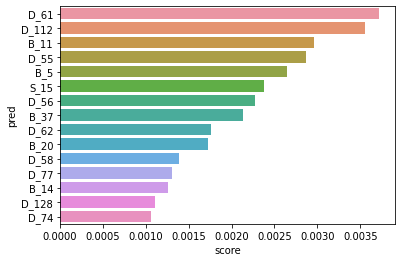

In [ ]:
# Permutation Feature importance

# Initialize a list of results
results = []
auc_full_mod=roc_auc_score(train_parquet['target'],model.predict_proba(train_parquet[not_best])[:,1])

# Iterate through each predictor
for predictor in train_parquet[not_best]:
    # Create a copy of x_test
    x_test_copy = train_parquet[not_best].copy()
    
    # Scramble the values of the given predictor
    x_test_copy[predictor] = train_parquet[not_best][predictor].sample(frac=1).values
    
    # Calculate the new MAE
    new_auc = roc_auc_score(train_parquet['target'], model.predict_proba(x_test_copy)[:,1])
    
    # Append the increase in MAE to the list of results 
    results.append({'pred': predictor,
                    'score': auc_full_mod - new_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)
del x_test_copy

# plot top 15
import seaborn as sns
sns.barplot(data=resultsdf.head(15),x='score',y='pred')

# print top 10
resultsdf.head(10)

In [ ]:
not_best=resultsdf['pred'].head(35).values

In [ ]:
len([col for col in train_parquet.columns if col not in predictors+['target','S_2']])
not_best

array(['D_61', 'D_112', 'B_11', 'D_55', 'B_5', 'S_15', 'D_56', 'B_37',
       'D_62', 'B_20', 'D_58', 'D_77', 'B_14', 'D_128', 'D_74', 'B_18',
       'D_129', 'D_72', 'D_91', 'D_54', 'D_49', 'D_102', 'R_16', 'R_10',
       'D_127', 'D_78', 'B_22', 'B_10', 'S_11', 'R_6', 'B_17', 'B_7',
       'D_122', 'D_70', 'D_115'], dtype=object)

**Train_test_split for the simple model**

In [ ]:
for col in best_cat:
  train_parquet[col]=train_parquet[col].astype('category')

In [ ]:
# Train test split
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test=train_test_split(train[predictors], train[['target']], test_size=0.2, random_state=42)
print(x_train.shape,x_test.shape)

(367130, 342) (91783, 342)


**Basic Model with target encoded bin features**

Here, I have used TargetEncoder from category_encoders module. It replaces bin categories with the target mean of observations falling into that category. Since we have large enough data in each category, we do not need the additional smoothing for target encoding.

In [ ]:
# !pip install category_encoders
from category_encoders  import TargetEncoder
te=TargetEncoder(cols=bin_cols,handle_missing='value',handle_unknown='value', min_samples_leaf=50, smoothing=0.0)
te.fit(x_train[bin_cols],y_train)
x_train[bin_cols]=te.transform(x_train[bin_cols])
x_test[bin_cols]=te.transform(x_test[bin_cols])
print(print(x_train.shape,x_test.shape))
x_train[bin_cols].head()

(730164, 203) (182542, 203)
None


,R_4_bin,B_12_bin,B_13_bin,R_5_bin,D_65_bin,B_19_bin,B_21_bin,D_69_bin,B_23_bin,D_73_bin,...,D_136_bin,D_137_bin,D_138_bin,D_139_bin,D_140_bin,D_141_bin,D_142_bin,D_143_bin,D_144_bin,D_145_bin
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.227749,0.139964,0.255690,0.224734,0.465204,0.123520,0.244866,0.247763,0.073034,0.25781,...,0.245384,0.245384,0.245384,0.232688,0.250753,0.232193,0.233149,0.234211,0.256184,0.232147
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.226114,0.139964,0.203656,0.366213,0.218606,0.124370,0.246248,0.247944,0.073034,0.25781,...,0.245384,0.245384,0.245384,0.233345,0.250767,0.234446,0.233149,0.232989,0.256684,0.232809
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.229406,0.314551,0.232617,0.224734,0.219296,0.121406,0.249175,0.248547,0.018265,0.25781,...,0.245384,0.245384,0.245384,0.231981,0.250324,0.234446,0.233149,0.231749,0.257832,0.235169
00000fd6641609c6ece5454664794f0340ad84dddce9a267a310b5ae68e9d8e5,0.228331,0.314551,0.389895,0.226466,0.218606,0.123331,0.247586,0.247763,0.018265,0.25781,...,0.245384,0.245384,0.245384,0.233054,0.248693,0.233120,0.233149,0.233770,0.256684,0.232809
00001b22f846c82c51f6e3958ccd81970162bae8b007e80662ef27519fcc18c1,0.227322,0.338920,0.178778,0.226826,0.218431,0.121406,0.247897,0.245772,0.073034,0.25781,...,0.245384,0.245384,0.245384,0.236472,0.251806,0.230462,0.233149,0.232290,0.260033,0.234213


In [ ]:
# import pickle
# target_enc = open("target_enc.pkl", "wb")
# pickle.dump(obj=te, file=target_enc)
# target_enc.close()


In [ ]:
import lightgbm as lgbm
from sklearn.metrics import roc_auc_score, f1_score, classification_report, confusion_matrix
model = lgbm.LGBMClassifier( 
                            colsample_bytree=0.6, early_stopping_round=50,
                          learning_rate=0.025, n_estimators=500,
                          num_leaves=60, objective='binary', reg_alpha=0.5, reg_lambda=5, 
                          subsample=0.8
                          )
model.fit(x_train,y_train,eval_set=[(x_train,y_train),(x_test,y_test)],
          verbose=20,eval_metric='AUC')

Training until validation scores don't improve for 50 rounds.
[20]	training's binary_logloss: 0.400513	training's auc: 0.946827	valid_1's binary_logloss: 0.40089	valid_1's auc: 0.94532
[40]	training's binary_logloss: 0.326184	training's auc: 0.949195	valid_1's binary_logloss: 0.327452	valid_1's auc: 0.947579
[60]	training's binary_logloss: 0.287607	training's auc: 0.950796	valid_1's binary_logloss: 0.28964	valid_1's auc: 0.948918
[80]	training's binary_logloss: 0.266042	training's auc: 0.952164	valid_1's binary_logloss: 0.268706	valid_1's auc: 0.950185
[100]	training's binary_logloss: 0.253267	training's auc: 0.953243	valid_1's binary_logloss: 0.256496	valid_1's auc: 0.951157
[120]	training's binary_logloss: 0.245183	training's auc: 0.954219	valid_1's binary_logloss: 0.24896	valid_1's auc: 0.952027
[140]	training's binary_logloss: 0.239865	training's auc: 0.955068	valid_1's binary_logloss: 0.244147	valid_1's auc: 0.952746
[160]	training's binary_logloss: 0.236126	training's auc: 0.9558

LGBMClassifier(colsample_bytree=0.6, early_stopping_round=50,
               learning_rate=0.025, n_estimators=500, num_leaves=60,
               objective='binary', reg_alpha=0.5, reg_lambda=5, subsample=0.8)

AUC= 0.9577596624345804
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93    135499
         1.0       0.80      0.81      0.80     47043

    accuracy                           0.90    182542
   macro avg       0.87      0.87      0.87    182542
weighted avg       0.90      0.90      0.90    182542



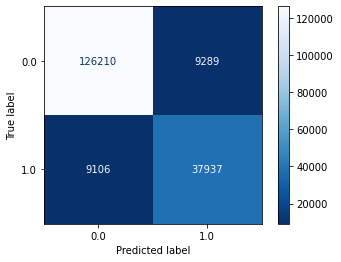

In [ ]:
import sklearn
print('AUC=',roc_auc_score(y_test,model.predict_proba(x_test)[:,1]))
print(classification_report(y_test,model.predict(x_test)))
sklearn.metrics.plot_confusion_matrix(model,x_test,y_test,cmap='Blues_r')

**The code below calculates permutation importance for each feature.** It includes following steps:
1. Calculate the basic model score for test data
2. Shuffle the feature values, and calculate the new score with shuffled dataset.
3. Calculate the score decrease by differencing model score and new score.
4. Iterate over features and Sort features in a decreasing order of score difference.

The features at the top are the most important, because shuffling them leads to the most decrease in the model performance.

,pred,score
67,bp12,0.025992
57,bp12,0.025821
66,bps,0.002279
76,bps,0.002263
17,D_43,0.001415
118,D_49,0.001125
20,D_46,0.001088
15,D_45,0.000967
29,D_39,0.000929
102,B_5,0.000914


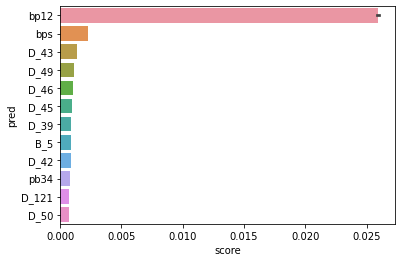

In [ ]:
# Permutation Feature importance

# Initialize a list of results
results = []
auc_full_mod=roc_auc_score(y_test,model.predict_proba(x_test)[:,1])

# Iterate through each predictor
for predictor in x_test:
    # Create a copy of x_test
    x_test_copy = x_test.copy()
    
    # Scramble the values of the given predictor
    x_test_copy[predictor] = x_test[predictor].sample(frac=1).values
    
    # Calculate the new MAE
    new_auc = roc_auc_score(y_test, model.predict_proba(x_test_copy)[:,1])
    
    # Append the increase in MAE to the list of results 
    results.append({'pred': predictor,
                    'score': auc_full_mod - new_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)
del x_test_copy

# plot top 15
import seaborn as sns
sns.barplot(data=resultsdf.head(15),x='score',y='pred')

# print top 10
resultsdf.head(10)

bp12 variable is the dominant feature, and the model seems to exploit it more and ignores other features. It may be a good idea to remove it and then run the model with other variables to get better understanding of the feature importances.

# Grid Search

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'boosting_type': 'gbdt', 
        'num_leaves': 64,
        'metric': 'auc'}

# Create parameters to search
grid_params = {'learning_rate': [0.025], 'n_estimators': [500],
              'num_leaves': [50,80], 
              'objective': ['binary'],
              'colsample_bytree': [0.5], 
              'subsample': [0.5, 0.7],
              'early_stopping_round':[20],
               'max_depth':[-1,7,13]
              }
mod = lgbm.LGBMClassifier(**params)

# Create the grid
grid_orig = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=4, n_jobs=-1,scoring='f1_weighted')
# Run the grid
grid_orig.fit(x_train, y_train, eval_set=[(x_val,y_val)])


In [ ]:
# Print the best parameters found
print(grid_orig.best_score_)
grid_orig.best_estimator_

0.8982637265367496


LGBMClassifier(colsample_bytree=0.5, early_stopping_round=20,
               learning_rate=0.025, max_depth=13, metric='auc',
               n_estimators=500, num_leaves=80, objective='binary',
               subsample=0.5)

AUC= 0.9577159465948677
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93    162576
         1.0       0.80      0.81      0.80     56473

    accuracy                           0.90    219049
   macro avg       0.87      0.87      0.87    219049
weighted avg       0.90      0.90      0.90    219049



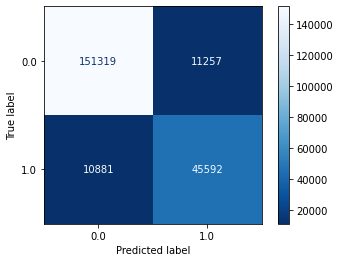

In [ ]:
best=grid_orig.best_estimator_
import sklearn
print('AUC=',roc_auc_score(y_val,best.predict_proba(x_val)[:,1]))
print(classification_report(y_val,best.predict(x_val)))
sklearn.metrics.plot_confusion_matrix(best,x_val,y_val,cmap='Blues_r')

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'boosting_type': 'gbdt', 
        'metric': 'auc'}

# Create parameters to search
grid_params = {'learning_rate': [0.025], 'n_estimators': [500],
              'num_leaves': [70,90], 
              'objective': ['binary'],
              'colsample_bytree': [0.4,0.6], 
              'subsample': [0.5],
              'early_stopping_round':[20],
               'max_depth':[10,15],
               'reg_alpha': [0,1],
              }
model = lgbm.LGBMClassifier(**params)

# Create the grid
grid_orig = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=4, n_jobs=-1,scoring='f1_weighted')
# Run the grid
grid_orig_1.fit(x_train, y_train, eval_set=[(x_val,y_val)])

In [ ]:
# Print the best parameters found
print(grid_orig_1.best_score_)
grid_orig_1.best_estimator_

0.8985536618841926


LGBMClassifier(colsample_bytree=0.4, early_stopping_round=20,
               learning_rate=0.025, max_depth=15, metric='auc',
               n_estimators=500, num_leaves=90, objective='binary', reg_alpha=1,
               subsample=0.5)

AUC= 0.957884013041058
              precision    recall  f1-score   support

         0.0       0.93      0.93      0.93    162576
         1.0       0.80      0.81      0.80     56473

    accuracy                           0.90    219049
   macro avg       0.87      0.87      0.87    219049
weighted avg       0.90      0.90      0.90    219049



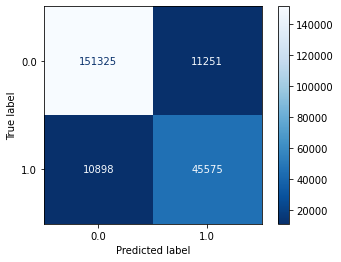

In [ ]:
#min_data_in_leaf = 20
best1=grid_orig_1.best_estimator_
import sklearn
print('AUC=',roc_auc_score(y_val,best1.predict_proba(x_val)[:,1]))
print(classification_report(y_val,best1.predict(x_val)))
sklearn.metrics.plot_confusion_matrix(best1,x_val,y_val,cmap='Blues_r')

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'boosting_type': 'gbdt', 
        'metric': 'auc'}

# Create parameters to search
grid_params = {'learning_rate': [0.02], 'n_estimators': [1000],
              'num_leaves': [90], 
              'objective': ['binary'],
              'colsample_bytree': [0.2,0.3,0.4], 
              'subsample': [0.4,0.5],
              'early_stopping_round':[20],
               'max_depth':[15,17],
               'reg_alpha': [1],
               'reg_lambda':[0,1]
              }
mod = lgbm.LGBMClassifier(**params)

# Create the grid
grid_orig_2 = GridSearchCV(mod, param_grid=grid_params, verbose=1, cv=3, n_jobs=-1,scoring='f1_weighted')
# Run the grid
grid_orig_2.fit(x_train, y_train, eval_set=[(x_val,y_val)])

In [ ]:
# Print the best parameters found
print(grid_orig_2.best_score_)
grid_orig_2.best_estimator_

0.8991068080846123


LGBMClassifier(colsample_bytree=0.3, early_stopping_round=20,
               learning_rate=0.02, max_depth=15, metric='auc',
               n_estimators=1000, num_leaves=90, objective='binary',
               reg_alpha=1, reg_lambda=1, subsample=0.4)

In [ ]:
a=[1,23,4]
b=[2,3,5]
df=pd.DataFrame()
df['target']=y_true
df['prediction']=y_pred
preds=df['target']
y_true=d



,target,prediction
0,1,2
1,23,3
2,4,5


In [ ]:
1. / (1. + np.exp(2))

0.11920292202211755

In [ ]:
def amex(preds, train_data) -> float:
    y_true=train_data.get_label()
    y_pred = 1. / (1. + np.exp(-preds))

    def amex_metric_mod(y_true, y_pred):

        labels     = np.transpose(np.array([y_true, y_pred]))
        labels     = labels[labels[:, 1].argsort()[::-1]]
        weights    = np.where(labels[:,0]==0, 20, 1)
        cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
        top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

        gini = [0,0]
        for i in [1,0]:
            labels         = np.transpose(np.array([y_true, y_pred]))
            labels         = labels[labels[:, i].argsort()[::-1]]
            weight         = np.where(labels[:,0]==0, 20, 1)
            weight_random  = np.cumsum(weight / np.sum(weight))
            total_pos      = np.sum(labels[:, 0] *  weight)
            cum_pos_found  = np.cumsum(labels[:, 0] * weight)
            lorentz        = cum_pos_found / total_pos
            gini[i]        = np.sum((lorentz - weight_random) * weight)

        return 0.5 * (gini[1]/gini[0] + top_four)
    return 'amex', amex_metric_mod(y_true,y_pred), True

In [ ]:
x_train.columns

Index(['ps', 'rp', 'rs', 'bps', 'r12', 'r23', 'b12', 'b23', 'p23', 'B_9',
       'B_8', 'B_4', 'B_3', 'B_40', 'B_16', 'B_28', 'B_25', 'B_15', 'B_6',
       'D_75', 'D_60', 'D_42', 'D_45', 'D_53', 'D_43', 'D_48', 'D_44', 'D_46',
       'D_50', 'D_47', 'D_41', 'D_71', 'D_52', 'D_51', 'D_121', 'D_132',
       'D_39', 'D_59', 'D_76', 'S_22', 'R_3', 'R_27', 'R_1', 'S_24', 'S_3',
       'S_5', 'S_25', 'S_13', 'S_23', 'R_9', 'S_9', 'S_26', 'S_8', 'R_12',
       'R_26', 'S_6', 'S_7', 'S_12', 'S_27', 'P_2', 'P_3', 'P_4', 'B_31',
       'B_30', 'B_38', 'D_63', 'D_64', 'D_66', 'D_68', 'D_87', 'D_114',
       'D_116', 'D_117', 'D_120', 'D_126'],
      dtype='object')

In [ ]:
model=lgbm.LGBMClassifier(boosting_type='dart',colsample_bytree=0.7, early_stopping_round=30,
               learning_rate=0.025, max_depth=15, metric='auc',
               n_estimators=500, num_leaves=90, objective='binary',
               reg_alpha=1, reg_lambda=1, subsample=0.7,min_split_gain=0.001,min_child_samples=50)
model.fit(x_train[selected],y_train, eval_set=[(x_train[selected],y_train),(x_test[selected],y_test)],
          verbose=20,eval_metric='AUC')

[20]	valid_0's auc: 0.939492	valid_1's auc: 0.938673
[40]	valid_0's auc: 0.940866	valid_1's auc: 0.939966
[60]	valid_0's auc: 0.941546	valid_1's auc: 0.9406
[80]	valid_0's auc: 0.942011	valid_1's auc: 0.941021
[100]	valid_0's auc: 0.942146	valid_1's auc: 0.941151
[120]	valid_0's auc: 0.94267	valid_1's auc: 0.941636
[140]	valid_0's auc: 0.942773	valid_1's auc: 0.941706
[160]	valid_0's auc: 0.942845	valid_1's auc: 0.941765
[180]	valid_0's auc: 0.94318	valid_1's auc: 0.942064
[200]	valid_0's auc: 0.943586	valid_1's auc: 0.942462
[220]	valid_0's auc: 0.943887	valid_1's auc: 0.942737
[240]	valid_0's auc: 0.944298	valid_1's auc: 0.943119
[260]	valid_0's auc: 0.94461	valid_1's auc: 0.943394
[280]	valid_0's auc: 0.944929	valid_1's auc: 0.943676
[300]	valid_0's auc: 0.945187	valid_1's auc: 0.9439
[320]	valid_0's auc: 0.94541	valid_1's auc: 0.944106
[340]	valid_0's auc: 0.945537	valid_1's auc: 0.944215
[360]	valid_0's auc: 0.945798	valid_1's auc: 0.94443
[380]	valid_0's auc: 0.945985	valid_1's a

LGBMClassifier(boosting_type='dart', colsample_bytree=0.7,
               early_stopping_round=30, learning_rate=0.025, max_depth=15,
               metric='auc', min_child_samples=50, min_split_gain=0.001,
               n_estimators=500, num_leaves=90, objective='binary', reg_alpha=1,
               reg_lambda=1, subsample=0.7)

AUC= 0.945917475182542
              precision    recall  f1-score   support

         0.0       0.92      0.92      0.92    378483
         1.0       0.77      0.78      0.78    131517

    accuracy                           0.88    510000
   macro avg       0.85      0.85      0.85    510000
weighted avg       0.88      0.88      0.88    510000



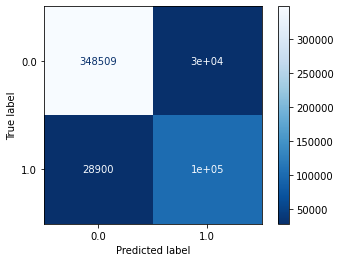

In [ ]:
import sklearn
print('AUC=',roc_auc_score(y_test,model.predict_proba(x_test[selected])[:,1]))
print(classification_report(y_test,model.predict(x_test[selected])))
sklearn.metrics.plot_confusion_matrix(model,x_test[selected],y_test,cmap='Blues_r')

# Understanding the custom metric

Ignore this part, as it does not impact the parts following it.

In [ ]:
import numpy as np
import pandas as pd

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum(), df
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum(), df

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        a2, df2 = weighted_gini(y_true, y_true_pred)
        a1, df1 =  weighted_gini(y_true, y_pred)
        return a1 / a2 , df1 , df2, a1, a2
    g , df1, df2 ,a1, a2 = normalized_weighted_gini(y_true, y_pred)
    d , df3 = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d), df1, df2, df3,  a1, a2


In [ ]:
check=holdout[['target','P_2']]
check['pred_prob']=model.predict_proba(holdout[selected])[:,1]
max_risk=holdout['P_2'].max()
check['pred_prob']=check['pred_prob']*check['P_2']/max_risk
final_y=check[['target']].groupby(by='customer_ID')['target'].max()
final_y=pd.DataFrame(final_y)
def predict_pr(values):
  return values[-1]
grouped=check[['pred_prob']].groupby(by='customer_ID')['pred_prob'].apply(list)
for i in range(len(grouped)):
  grouped[i]=predict_pr(grouped[i])
final=pd.DataFrame(grouped)
final.columns=['prediction']


In [ ]:
score, df1, df2, df3, a1 , a2 = amex_metric(final_y, final)
score

0.6712936360562699

In [ ]:
holdout[holdout['P_2']<0]['target'].mean()

0.9336573830793484

In [ ]:
df2[df2['target']==0].head()

,target,prediction,weight,random,cum_pos_found,lorentz,gini
customer_ID,,,,,,,
a06e6c13f12b3a19647feae020aa20e0c7c07f79d6828a1b0fadfb9b60d68694,0.0,0.0,20,0.017141,18973.0,1.0,19.657182
a4159ca38b281c76528e0c2c1eff91cbc62bef86363db4b35ec50e743e93c1f8,0.0,0.0,20,0.017159,18973.0,1.0,19.656821
a3ffc108e931e206790ba7095133e2db660a86b578c415214bc6c0586ea0bd92,0.0,0.0,20,0.017177,18973.0,1.0,19.656460
955bef8b4373e0ba9067c733214d0de0dbd515530a59dc4a380317601f6600a9,0.0,0.0,20,0.017195,18973.0,1.0,19.656099
a3dbd15972a7049bc6472056c383b83b3e0c22abd47cac49f0bf874442a74186,0.0,0.0,20,0.017213,18973.0,1.0,19.655738


In [ ]:
df1.iloc[14000:14010]

,target,prediction,weight,random,cum_pos_found,lorentz,gini
customer_ID,,,,,,,
a7828d7f9eb254ed49fc4cc5ca583a49b83cc8fa57d1ec3dc1c5100cf7f4fa23,0.0,0.693672,20,0.041340,12327.0,0.649713,12.167453
6f4e335e09057351810cb77eeebd9a93178ab2872084bf6b9bb167ab21e571f7,1.0,0.693661,1,0.041341,12328.0,0.649765,0.608424
8e5ac382364b50995da7053d77a561b91001f6d68e3ed61004d0caaf1a50fb02,0.0,0.693649,20,0.041359,12328.0,0.649765,12.168128
88cfa2acf5a45ebf373e78572f9e72f77ab40b8594604ba9cf961d84a65d16ae,1.0,0.693575,1,0.041360,12329.0,0.649818,0.608458
cb3e2462367fa00ff875d2941c55429b7900a712b9593bd3bb1e5a588b5cdff7,1.0,0.693532,1,0.041361,12330.0,0.649871,0.608510
5197b8b1ad65fa658539593de34b82cfe4d4a5435b8a57a6888c45d5a2cb0ee7,0.0,0.693508,20,0.041379,12330.0,0.649871,12.169840
6c69aff7243e582166eda15288ff76fc9bbb28dd0be04a649c17037aea7dfa77,1.0,0.69345,1,0.041380,12331.0,0.649924,0.608544
3107e9ba887cb5b5a0d09b385403b8c092061eba9f3c5f4b72db28a54cd6391a,1.0,0.693426,1,0.041381,12332.0,0.649976,0.608596
2de3d7aa6a38e71d2afe6925669e4318d4ed8f8bd1cc3777bc007811d0044ce1,1.0,0.693405,1,0.041382,12333.0,0.650029,0.608647


In [ ]:
df2.iloc[10000:10010]

,target,prediction,weight,weight_cumsum
customer_ID,,,,
df35929f3432ebfa035f053c55bb112751615a8562345a96410e38325436afa2,1.0,0.817541,1,22940
218dd0d4907e564b13912abbe6a52dc6ad61e3acead42d29cfe24e1d906994da,1.0,0.817522,1,22941
01c894d1056f6c1aa392f58bcb0fab2ebdcc7ceca912f78c07333b30596de932,1.0,0.817507,1,22942
a22b9b28043d7329ab0138e71c8dc658d433f7137b2008c79b98a2c57c322748,1.0,0.817506,1,22943
30f7754282501986b670bbf0c2ecc97998a2f8fa792c54bbf32f8a3e11bf5be2,1.0,0.817485,1,22944
815c69fa259eb454b582726720712e0fea2df7565d01cd5b808d095d903060b4,1.0,0.817464,1,22945
2d7cb317a65f57c2be537e4265fe79e9b7c5b9729c0b02a828096b6154d24ea6,0.0,0.817451,20,22965
3f41a43a902b53ab64177808229f99c88820ad3d6f5bdf270d5a8ccd59e3f7c1,1.0,0.81745,1,22966
3eb3f945765613ec3d8d3913e58ded8fd395f253da6cc56f810fc8605fab99c0,1.0,0.817434,1,22967


# Post Analysis

## Shap values

In [ ]:
#!pip install shap
import shap
# print the JS visualization code to the notebook
shap.initjs()

In [ ]:
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(x_test)

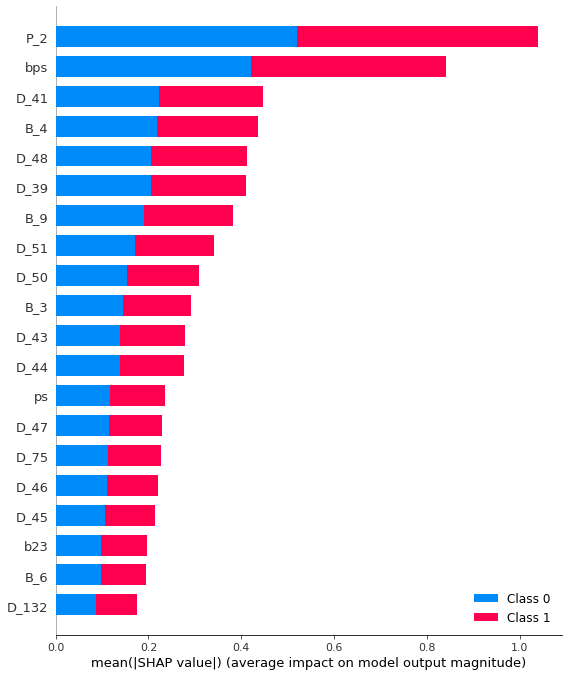

In [ ]:
shap.summary_plot(shap_values, x_test,)

In [ ]:
# Residual analysis
test_yhat = x_test.copy()
test_yhat['predicted']=model.predict(x_test)
test_yhat['target']=y_test['target']
yhat = 'p_default'
resid = 'r_default'
test_yhat[yhat] = model.predict_proba(x_test)[:,1]
y='target'
test_yhat['s'] = 1
test_yhat.loc[test_yhat[y] == 0, 's'] = -1
# calculate the residuals for binary logloss
test_yhat[resid] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
                                              ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
test_yhat = test_yhat.drop('s', axis=1)

# add shap contributions to the data
cols_shap=[col+'_cont' for col in x_test.columns]
test_yhat[cols_shap]=shap_values[1]

#sort the set by residuals
test_yhat = test_yhat.sort_values(by=resid, ascending=False).reset_index(drop=True)

# Define feature_values and shap values
shap_columns = cols_shap.copy()
ftr_columns = x_test.columns.copy()
shap_contribs = test_yhat[cols_shap]
ftr_values =test_yhat[ftr_columns]

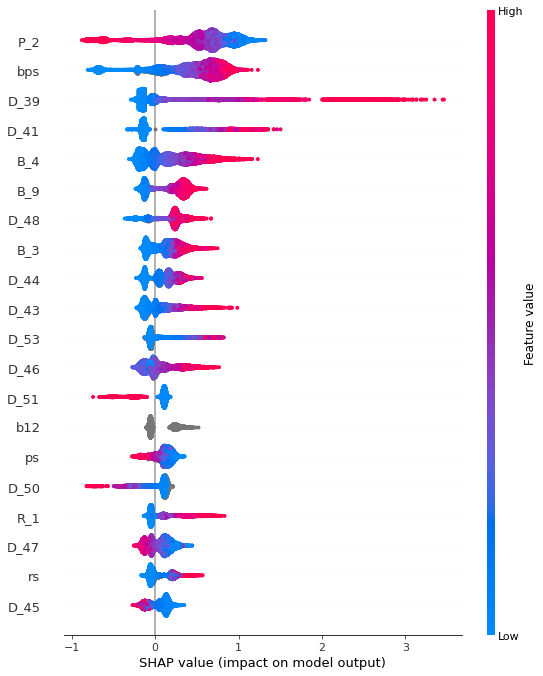

In [ ]:
shap.summary_plot(shap_values=shap_contribs.values[0:20000],
                  features=ftr_values[0:20000])

In [ ]:
test_yhat[[resid,'target']]

,r_default,target
0,3.949589,1.0
1,3.840026,1.0
2,3.739227,1.0
3,3.730583,1.0
4,3.697003,1.0
...,...,...
73422,-3.289392,0.0
73423,-3.313801,0.0
73424,-3.341342,0.0
73425,-3.578163,0.0


### True Negatives

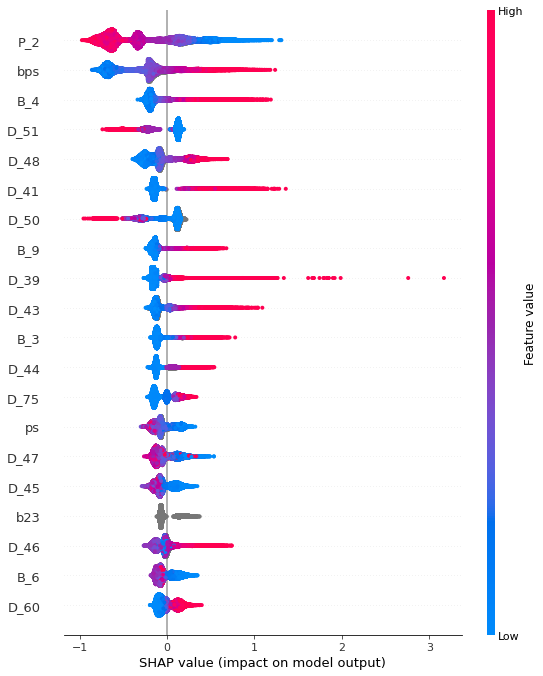

In [ ]:
true_neg=test_yhat[(test_yhat['predicted']==0)&(test_yhat['target']==0)]
fn_con=true_neg[cols_shap]
fn_features =true_neg[ftr_columns]
shap.summary_plot(shap_values=fn_con.values,
                  features=fn_features,)

### True positives

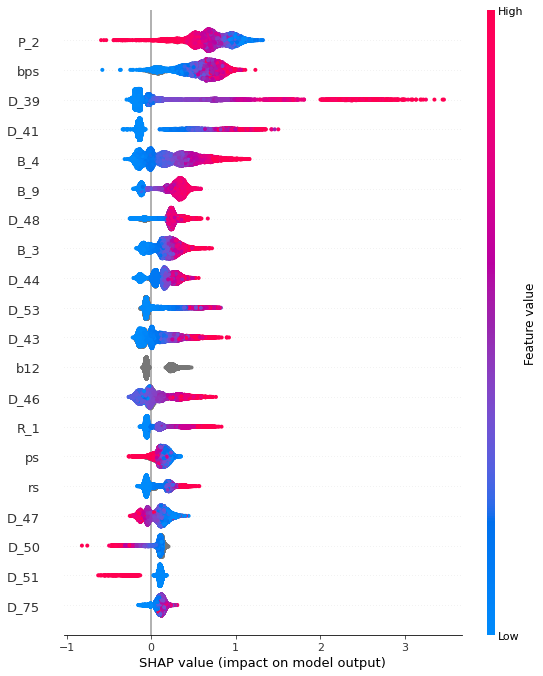

In [ ]:
true_pos=test_yhat[(test_yhat['predicted']==1)&(test_yhat['target']==1)]
fn_con=true_pos[cols_shap]
fn_features =true_pos[ftr_columns]
shap.summary_plot(shap_values=fn_con.values,
                  features=fn_features,)

### False negative - largest contirbutors

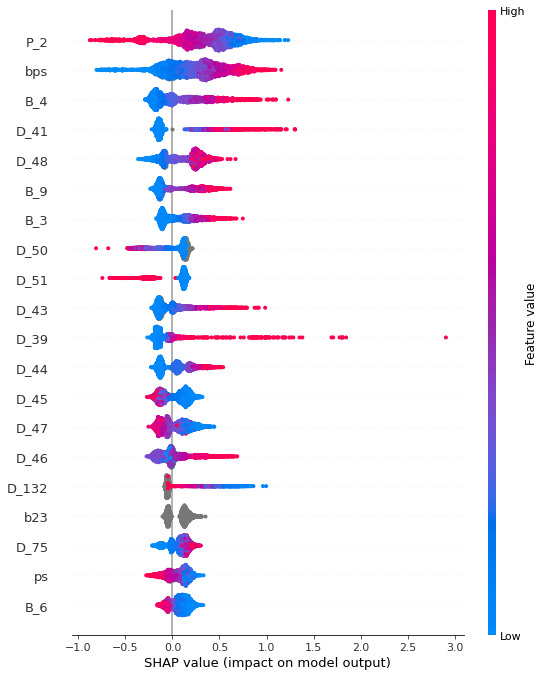

In [ ]:
false_neg=test_yhat[(test_yhat['predicted']==0)&(test_yhat['target']==1)]
fn_con=false_neg[cols_shap]
fn_features =false_neg[ftr_columns]
shap.summary_plot(shap_values=fn_con.values,
                  features=fn_features,)

In [ ]:
false_neg[['target','p_default']]

,target,p_default
0,1.0,0.000410
1,1.0,0.000628
2,1.0,0.000920
3,1.0,0.000950
4,1.0,0.001077
...,...,...
3793,1.0,0.499416
3794,1.0,0.499519
3795,1.0,0.499764
3796,1.0,0.499946


### False positive - largest contributors

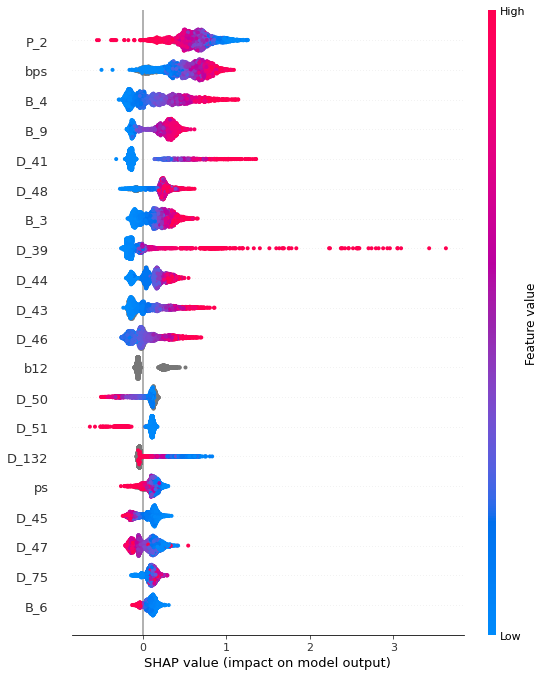

In [ ]:
false_pos=test_yhat[(test_yhat['predicted']==1)&(test_yhat['target']==0)]
fn_con=false_pos[cols_shap]
fn_features =false_pos[ftr_columns]
shap.summary_plot(shap_values=fn_con.values,
                  features=fn_features,)

### Individual SHAP contibutions

In [ ]:
# create a function to get local shap plot
def ind_shap_plot(explainer, combined_df, shap_columns, ftr_columns, index):
  return shap.force_plot(explainer.expected_value[1], combined_df[shap_columns].iloc[index,:].values,
                         combined_df[ftr_columns].iloc[index,:],link="logit")

In [ ]:
shap.initjs()
ind_shap_plot(explainer, false_neg, shap_columns, ftr_columns,0) # highest residual

In [ ]:
shap.initjs()
ind_shap_plot(explainer, false_neg, shap_columns, ftr_columns,3700) # highest residual

## Permutation importance

In [ ]:
# Initialize a list for model score contribution for the features
results = []
auc_full_mod=roc_auc_score(y_test,model.predict_proba(x_test)[:,1])

# Iterate through each predictor
for predictor in x_test:
    # Create a copy of x_test
    x_test_copy = x_test.copy()
    
    # Scramble the values of the given predictor
    x_test_copy[predictor] = x_test[predictor].sample(frac=1).values
    
    # Calculate the new MAE
    new_auc = roc_auc_score(y_test, model.predict_proba(x_test_copy)[:,1])
    
    # Append the increase in MAE to the list of results 
    results.append({'pred': predictor,
                    'score': auc_full_mod - new_auc})
# Convert to a pandas dataframe and rank the predictors by score
resultsdf = pd.DataFrame(results).sort_values(by = 'score',
                                              ascending = False)
for dl in [x_test_copy,results]:
  del dl

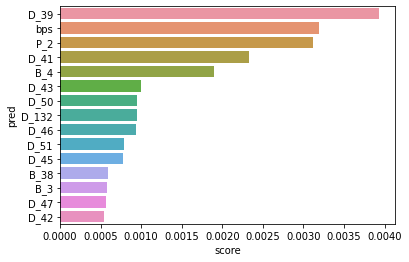

In [ ]:
import seaborn as sns
sns.barplot(data=resultsdf.head(15),x='score',y='pred')

In [ ]:
resultsdf.head(25).values

array([['D_39', 0.003929204315451407],
       ['bps', 0.0031977899030055656],
       ['P_2', 0.0031187263149331512],
       ['D_41', 0.002331705571646414],
       ['B_4', 0.0019007782855643418],
       ['D_43', 0.0009977547025044053],
       ['D_50', 0.0009527866515984806],
       ['D_132', 0.0009440841882287776],
       ['D_46', 0.000942087393441482],
       ['D_51', 0.0007921632399926493],
       ['D_45', 0.0007823999491453071],
       ['B_38', 0.0005981982917730999],
       ['B_3', 0.0005769875496658416],
       ['D_47', 0.0005634000531934413],
       ['D_42', 0.0005445674617367002],
       ['D_121', 0.0004936216092771284],
       ['D_48', 0.0004764509163420749],
       ['B_9', 0.00047040536120812604],
       ['D_60', 0.00043356483615220043],
       ['D_53', 0.0004214146834793375],
       ['ps', 0.00035947629665289416],
       ['D_44', 0.0003490112723002481],
       ['B_16', 0.000306781433926262],
       ['D_66', 0.00028966300803834333],
       ['D_59', 0.00024559220811071203]], dty

In [ ]:
# view the feature importance dataframe
resultsdf

,pred,score
36,D_39,3.929204e-03
3,bps,3.197790e-03
59,P_2,3.118726e-03
30,D_41,2.331706e-03
11,B_4,1.900778e-03
...,...,...
74,D_126,3.871633e-06
71,D_116,2.675298e-06
69,D_87,0.000000e+00
4,r12,-7.588401e-07


In [ ]:
selected=resultsdf.head(25)['pred'].values

In [ ]:
[col for col in selected if col not in x_train.columns]

[]

In [ ]:
train_parquet

,B_9,B_8,B_4,B_3,B_40,B_16,B_28,B_25,B_15,B_6,...,ps,rp,rs,bps,r12,r23,b12,b23,p23,target
customer_ID,,,,,,,,,,,,,,,,,,,,,
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.006822,0.004835,0.013713,0.009817,0.007535,0.003529,0.024448,0.008977,0.044198,0.122928,...,9.250158,0.001881,0.000184,-0.838235,False,True,False,True,True,0.0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.007081,0.002090,0.005182,0.006073,0.001404,0.000227,0.005743,0.003785,0.007219,0.221899,...,8.645185,0.002041,0.000178,-0.762037,False,False,False,True,True,0.0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.006717,0.006014,0.000836,0.003238,0.003697,0.008577,0.005608,0.009860,0.007769,0.166090,...,9.200991,0.008986,0.000808,-0.807692,True,False,False,True,True,0.0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.001064,0.003083,0.080204,0.007454,0.100918,0.005605,0.098844,0.009573,0.042265,0.150155,...,9.101823,0.000648,0.000063,-0.826910,False,False,False,True,True,0.0
0000099d6bd597052cdcda90ffabf56573fe9d7c79be5fbac11a8ed792feb62a,0.009535,0.002927,0.070793,0.007174,0.100454,0.006408,0.084745,0.006475,0.014553,0.149564,...,6.922946,0.006530,0.000824,-0.792549,False,True,False,True,True,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681,0.013776,0.000668,0.000029,0.025139,0.002501,0.835932,0.017920,0.021410,0.010653,0.122715,...,10.792388,0.003561,0.000316,-0.863450,True,True,False,True,True,0.0
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681,0.005645,0.006863,0.014354,0.023691,0.028988,0.755125,0.024238,0.007603,0.010991,0.171524,...,12.328874,0.005994,0.000472,-0.881330,False,True,False,True,True,0.0
fffff1d38b785cef84adeace64f8f83db3a0c31e8d92eaba8b115f71cab04681,0.004090,0.002050,0.016425,0.012343,0.026152,0.757985,0.018846,0.000706,0.012185,0.181703,...,9.781033,0.003516,0.000347,-0.870173,False,False,False,True,True,0.0


## LGB Model with competition metric

In [ ]:
#metric fot lgb
def amex(preds, train_data) -> float:
    y_true=train_data.get_label()
    y_pred = 1. / (1. + np.exp(-preds))

    def amex_metric_mod(y_true, y_pred):

        labels     = np.transpose(np.array([y_true, y_pred]))
        labels     = labels[labels[:, 1].argsort()[::-1]]
        weights    = np.where(labels[:,0]==0, 20, 1)
        cut_vals   = labels[np.cumsum(weights) <= int(0.04 * np.sum(weights))]
        top_four   = np.sum(cut_vals[:,0]) / np.sum(labels[:,0])

        gini = [0,0]
        for i in [1,0]:
            labels         = np.transpose(np.array([y_true, y_pred]))
            labels         = labels[labels[:, i].argsort()[::-1]]
            weight         = np.where(labels[:,0]==0, 20, 1)
            weight_random  = np.cumsum(weight / np.sum(weight))
            total_pos      = np.sum(labels[:, 0] *  weight)
            cum_pos_found  = np.cumsum(labels[:, 0] * weight)
            lorentz        = cum_pos_found / total_pos
            gini[i]        = np.sum((lorentz - weight_random) * weight)

        return 0.5 * (gini[1]/gini[0] + top_four)
    return 'amex', amex_metric_mod(y_true,y_pred), True

In [ ]:
import lightgbm as lgb
lgb_train = lgb.Dataset(x_train, label=y_train,
                         free_raw_data=False, categorical_feature=best_cat)
lgb_eval = lgb.Dataset(x_test, label=y_test, reference=lgb_train,
                        free_raw_data=False, categorical_feature=best_cat)

In [ ]:
dtrain= lgb.Dataset(train_parquet[predictors],label = train_parquet[['target']]
                         free_raw_data=False,categorical_feature=best_cat)

In [ ]:
# ac = gbm.best_score['valid_1']['amex']
# print(ac)
# remember for optuna to adjust the model

In [ ]:
params = {'bagging_fraction': 0.8,
          'objective':'binary',
          'boosting_type':'dart',
          'drop_rate':0.2,
        'bagging_freq': 20,
        'feature_fraction': 0.4,
        'lambda_l1': 0.0001,
        'lambda_l2': 20,
        'learning_rate': 0.025,
        #'max_depth': 30,
        #'min_child_samples': 190,
        'min_data_in_leaf': 80,
        'min_split_gain': 7e-05,
        'n_estimators': 2000,
        'num_leaves': 80}
gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_eval],
                    feval=amex,
                    early_stopping_rounds=200, verbose_eval=50
                    )

[50]	valid_0's binary_logloss: 0.380103	valid_0's amex: 0.75625
[100]	valid_0's binary_logloss: 0.360991	valid_0's amex: 0.759478
[150]	valid_0's binary_logloss: 0.339355	valid_0's amex: 0.762289
[200]	valid_0's binary_logloss: 0.306264	valid_0's amex: 0.764284
[250]	valid_0's binary_logloss: 0.309744	valid_0's amex: 0.765408
[300]	valid_0's binary_logloss: 0.277501	valid_0's amex: 0.768148
[350]	valid_0's binary_logloss: 0.266785	valid_0's amex: 0.770506
[400]	valid_0's binary_logloss: 0.255667	valid_0's amex: 0.773103
[450]	valid_0's binary_logloss: 0.249436	valid_0's amex: 0.774937
[500]	valid_0's binary_logloss: 0.243958	valid_0's amex: 0.775564
[550]	valid_0's binary_logloss: 0.240395	valid_0's amex: 0.776766
[600]	valid_0's binary_logloss: 0.236866	valid_0's amex: 0.777869
[650]	valid_0's binary_logloss: 0.231606	valid_0's amex: 0.778762
[700]	valid_0's binary_logloss: 0.229535	valid_0's amex: 0.780934
[750]	valid_0's binary_logloss: 0.229483	valid_0's amex: 0.781688
[800]	valid_

In [ ]:
import pickle
lgb_79 = open("lgb_79.pkl", "wb")
pickle.dump(obj=lgb_79, file=lgb_79)
lgb_79.close()


In [ ]:
import numpy as np
import pandas as pd

def amex_metric(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:

    def top_four_percent_captured(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        four_pct_cutoff = int(0.04 * df['weight'].sum())
        df['weight_cumsum'] = df['weight'].cumsum()
        df_cutoff = df.loc[df['weight_cumsum'] <= four_pct_cutoff]
        return (df_cutoff['target'] == 1).sum() / (df['target'] == 1).sum()
        
    def weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        df = (pd.concat([y_true, y_pred], axis='columns')
              .sort_values('prediction', ascending=False))
        df['weight'] = df['target'].apply(lambda x: 20 if x==0 else 1)
        df['random'] = (df['weight'] / df['weight'].sum()).cumsum()
        total_pos = (df['target'] * df['weight']).sum()
        df['cum_pos_found'] = (df['target'] * df['weight']).cumsum()
        df['lorentz'] = df['cum_pos_found'] / total_pos
        df['gini'] = (df['lorentz'] - df['random']) * df['weight']
        return df['gini'].sum()

    def normalized_weighted_gini(y_true: pd.DataFrame, y_pred: pd.DataFrame) -> float:
        y_true_pred = y_true.rename(columns={'target': 'prediction'})
        return weighted_gini(y_true, y_pred) / weighted_gini(y_true, y_true_pred)
    g = normalized_weighted_gini(y_true, y_pred)
    d = top_four_percent_captured(y_true, y_pred)

    return 0.5 * (g + d)


In [ ]:
x=x_test
x['pred_prob']=gbm.predict(x_test)
x['target']=y_test['target']
group=x[['pred_prob']].groupby(by='customer_ID')['pred_prob'].apply(list)
print(group.head())
from copy import deepcopy
def group_if(values):
  return values[-1]
group2=deepcopy(group)
for i in range(len(group2)):
  group2[i]=group_if(group2[i])
final2=pd.DataFrame(group2)
final2.columns=['prediction']
labels=x[['target']].groupby(by='customer_ID')['target'].max()
labels=pd.DataFrame(labels)
labels.columns=['target']
print(labels.head(4))
print(final2.head(4))
print(amex_metric(labels, final2[['prediction']])) 

In [ ]:
gbm.predict(x_test)

array([0.27199299, 0.81091455, 0.91327378, ..., 0.003665  , 0.02899839,
       0.00176673])

In [ ]:
params = {
        'objective':'binary',
         #'boosting_type':'dart' ,
        'bagging_fraction': 0.8771961999216402,
        'bagging_freq': 70,
        'feature_fraction': 0.42,
        'lambda_l1': 0.0001,
        'lambda_l2': 30,
        'learning_rate': 0.017,
        'max_depth': 25,
        'min_child_samples': 190,
        'min_data_in_leaf': 150,
        'min_split_gain': 7e-05,
        'n_estimators': 5000,
        'num_leaves': 200}
gbm = lgb.train(params,
                    lgb_train,
                    valid_sets=[lgb_train,lgb_eval],
                    feval=amex,
                    early_stopping_rounds=100
                    )

[1]	training's binary_logloss: 0.562363	training's amex: 0.706305	valid_1's binary_logloss: 0.561423	valid_1's amex: 0.702361
[2]	training's binary_logloss: 0.553358	training's amex: 0.72373	valid_1's binary_logloss: 0.5525	valid_1's amex: 0.718727
[3]	training's binary_logloss: 0.544756	training's amex: 0.727871	valid_1's binary_logloss: 0.543996	valid_1's amex: 0.722222
[4]	training's binary_logloss: 0.536521	training's amex: 0.732985	valid_1's binary_logloss: 0.535845	valid_1's amex: 0.727415
[5]	training's binary_logloss: 0.528612	training's amex: 0.732616	valid_1's binary_logloss: 0.528023	valid_1's amex: 0.726433
[6]	training's binary_logloss: 0.521255	training's amex: 0.737252	valid_1's binary_logloss: 0.520763	valid_1's amex: 0.729817
[7]	training's binary_logloss: 0.513932	training's amex: 0.737442	valid_1's binary_logloss: 0.51352	valid_1's amex: 0.729404
[8]	training's binary_logloss: 0.516603	training's amex: 0.737375	valid_1's binary_logloss: 0.516159	valid_1's amex: 0.728

KeyboardInterrupt: ignored

In [ ]:
1/(1+np.exp(-gbm.predict(x_test)))

array([0.57636945, 0.70256278, 0.70370854, ..., 0.50061656, 0.49259277,
       0.50120361])

## Optuna

In [ ]:
import optuna.integration.lightgbm as lgb
import optuna
from sklearn.model_selection import RepeatedKFold

In [ ]:

# rkf = RepeatedKFold(n_splits=10, n_repeats=10, random_state=42)

# params = {
#         "objective": "binary",
#         "metric": "amex",
#         "verbosity": -1,
#         "boosting_type": "gbdt",                
#         "seed": 42
#     }

# # X = np.array( train[discrete_features + continuous_features] )    
# # y = np.array( train['Survived'] ).flatten()

# study_tuner = optuna.create_study(direction='maximize')
# # dtrain = lgb.Dataset(X, label=y)

# # Suppress information only outputs - otherwise optuna is 
# # quite verbose, which can be nice, but takes up a lot of space
# optuna.logging.set_verbosity(optuna.logging.WARNING) 

# # Run optuna LightGBMTunerCV tuning of LightGBM with cross-validation
# tuner = lgb.LightGBMTunerCV(params, 
#                             lgb_train, 
#                             study=study_tuner,
#                             verbose_eval=False,                            
#                             early_stopping_rounds=250,
#                             time_budget=1980, # Time budget of 5 hours, we will not really need it
#                             seed = 42,
#                             folds=rkf,
#                             num_boost_round=1000,
#                             callbacks=[lgb.reset_parameter(learning_rate = [0.005]*200 + [0.001]*9800) ] #[0.1]*5 + [0.05]*15 + [0.01]*45 + 
#                            )

# tuner.run()

In [ ]:
gbm.best_score['valid_0']

{'amex': 0.7911685836426683, 'binary_logloss': 0.21875110103503384}

In [ ]:
!pip install optuna
# from sklearn.model_selection import StratifiedKFold
import optuna
import lightgbm as lgb

In [ ]:
# dtrain = lgb.Dataset(train_parquet[predictors], label=train_parquet['target'],)
# num_folds=5
# folds=StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=326)

# to track performance
best_score=0.9
training_rounds=10000

lgb_train = lgb.Dataset(x_train, label=y_train,
                         free_raw_data=False, categorical_feature=best_cat)
lgb_eval = lgb.Dataset(x_test, label=y_test, reference=lgb_train,
                        free_raw_data=False, categorical_feature=best_cat)

def objective(trial):
    # 
    param={
          'objective':'binary',
          'verbosity':-1,
          'boosting_type':'gbdt',
          "max_depth": trial.suggest_int("max_depth", 3, 30),
          "lambda_l1": trial.suggest_loguniform("lambda_l1", 0.0001, 40),
          "lambda_l2": trial.suggest_loguniform("lambda_l2", 0.0001, 100), 
          "num_leaves": trial.suggest_int("num_leaves", 20, 400),
          "n_estimators": trial.suggest_categorical("n_estimators", [3000]),
          "learning_rate": trial.suggest_uniform("learning_rate", 0.001, 0.3),
          "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.2, 0.90),
          "bagging_freq": trial.suggest_int("bagging_freq", 1,70),
          "feature_fraction": trial.suggest_uniform("feature_fraction", 0.2, 0.90), 
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20, 200),
          'min_child_samples': trial.suggest_int("min_child_samples", 10, 200),
          "min_split_gain": trial.suggest_loguniform("min_split_gain", 0.00001, 15),
          'feature_pre_filter':False,
          "seed": 2021
            }
    # run model     

    lgb_train = lgb.Dataset(x_train, label=y_train,
                         free_raw_data=False)
    lgb_eval = lgb.Dataset(x_test, label=y_test, reference=lgb_train,
                        free_raw_data=False)
    
    gbm = lgb.train(param,
                    lgb_train,
                    valid_sets=[lgb_eval],
                    feval=amex,
                    early_stopping_rounds=100
                    )

    # lgbcv=lgb.cv( 
    #               param, 
    #               dtrain,
    #               folds = folds,
    #               feval = amex,
    #               verbose_eval = 100,
    #               early_stopping_rounds = 250
    #             )
    # cv_score=lgbcv['amex-mean'][-1]+lgbcv['amex-stdv'][-1]
    cv_score=gbm.best_score['valid_0']['amex']
    # if cv_score<best_score:
    #   training_round=len( list(lgbcv.values())[0] )
    return cv_score

# # Suppress information only outputs
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study_name = "example-study-1"  # Unique identifier of the study.
# storage_name = "sqlite:///{}.db".format(study_name)
# study = optuna.create_study(direction='maximize',study_name=study_name, storage=storage_name)
# study.optimize(objective,n_trials=20)

In [ ]:
tmp_best_params = study.best_params
tmp_best_params

{'bagging_fraction': 0.8905761898102242,
 'bagging_freq': 37,
 'feature_fraction': 0.48777952671388436,
 'lambda_l1': 0.2539379561647432,
 'lambda_l2': 1.4994333132392244,
 'learning_rate': 0.03182013229199411,
 'max_depth': 5,
 'min_child_samples': 200,
 'min_data_in_leaf': 119,
 'min_split_gain': 0.0048596800313904865,
 'n_estimators': 3000,
 'num_leaves': 58}

In [ ]:
study = optuna.create_study(direction='maximize',study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective,n_trials=50) 

In [ ]:
study.best_params

{'bagging_fraction': 0.7610136299569118,
 'bagging_freq': 63,
 'feature_fraction': 0.4504588371252062,
 'lambda_l1': 0.40428165265774546,
 'lambda_l2': 10.317865929982577,
 'learning_rate': 0.02342988047723457,
 'max_depth': 24,
 'min_child_samples': 200,
 'min_data_in_leaf': 180,
 'min_split_gain': 0.0003115492782185107,
 'n_estimators': 3000,
 'num_leaves': 97}

In [ ]:
study.best_value

0.7922949302565574

In [ ]:
optuna.visualization.plot_optimization_history(study)

In [ ]:
optuna.visualization.plot_slice(study)

In [ ]:
optuna.visualization.plot_param_importances(study)


In [ ]:
study = optuna.create_study(direction='maximize',study_name=study_name, storage=storage_name, load_if_exists=True)
study.optimize(objective,n_trials=50) 

Streaming output truncated to the last 5000 lines.
[1134]	valid_0's binary_logloss: 0.221055	valid_0's amex: 0.788834
[1135]	valid_0's binary_logloss: 0.221052	valid_0's amex: 0.788644
[1136]	valid_0's binary_logloss: 0.221048	valid_0's amex: 0.788646
[1137]	valid_0's binary_logloss: 0.221046	valid_0's amex: 0.788752
[1138]	valid_0's binary_logloss: 0.221041	valid_0's amex: 0.788796
[1139]	valid_0's binary_logloss: 0.221036	valid_0's amex: 0.788926
[1140]	valid_0's binary_logloss: 0.221031	valid_0's amex: 0.788843
[1141]	valid_0's binary_logloss: 0.221026	valid_0's amex: 0.788823
[1142]	valid_0's binary_logloss: 0.221022	valid_0's amex: 0.788782
[1143]	valid_0's binary_logloss: 0.221017	valid_0's amex: 0.788763
[1144]	valid_0's binary_logloss: 0.221011	valid_0's amex: 0.788786
[1145]	valid_0's binary_logloss: 0.221006	valid_0's amex: 0.788873
[1146]	valid_0's binary_logloss: 0.221003	valid_0's amex: 0.788916
[1147]	valid_0's binary_logloss: 0.220998	valid_0's amex: 0.788875
[1148]	vali

{'bagging_fraction': 0.7610136299569118,
 'bagging_freq': 63,
 'feature_fraction': 0.4504588371252062,
 'lambda_l1': 0.40428165265774546,
 'lambda_l2': 10.317865929982577,
 'learning_rate': 0.02342988047723457,
 'max_depth': 24,
 'min_child_samples': 200,
 'min_data_in_leaf': 180,
 'min_split_gain': 0.0003115492782185107,
 'n_estimators': 3000,
 'num_leaves': 97}

In [ ]:
study.best_params # from the first one

{'bagging_fraction': 0.7610136299569118,
 'bagging_freq': 63,
 'feature_fraction': 0.4504588371252062,
 'lambda_l1': 0.40428165265774546,
 'lambda_l2': 10.317865929982577,
 'learning_rate': 0.02342988047723457,
 'max_depth': 24,
 'min_child_samples': 200,
 'min_data_in_leaf': 180,
 'min_split_gain': 0.0003115492782185107,
 'n_estimators': 3000,
 'num_leaves': 97}

In [ ]:
study.best_params

{'bagging_fraction': 0.7610136299569118,
 'bagging_freq': 63,
 'feature_fraction': 0.4504588371252062,
 'lambda_l1': 0.40428165265774546,
 'lambda_l2': 10.317865929982577,
 'learning_rate': 0.02342988047723457,
 'max_depth': 24,
 'min_child_samples': 200,
 'min_data_in_leaf': 180,
 'min_split_gain': 0.0003115492782185107,
 'n_estimators': 3000,
 'num_leaves': 97}

# Dart model with LGBM


In [ ]:

def objective(trial):
    # 
    param={
          'objective':'binary',
          'verbosity':-1,
          'boosting_type':'dart',
          'drop_rate':  trial.suggest_uniform("bagging_fraction", 0.1, 0.5),
          "max_depth": trial.suggest_int("max_depth", 20, 40),
          "lambda_l1": trial.suggest_loguniform("lambda_l1", 0.0001, 5),
          "lambda_l2": trial.suggest_loguniform("lambda_l2", 0.0001, 20), 
          "num_leaves": trial.suggest_int("num_leaves", 50, 250),
          "n_estimators": trial.suggest_categorical("n_estimators", [3000]),
          "learning_rate": trial.suggest_uniform("learning_rate", 0.005, 0.05),
          "bagging_fraction": trial.suggest_uniform("bagging_fraction", 0.4, 0.90),
          "bagging_freq": trial.suggest_int("bagging_freq", 10,65),
           'neg_bagging':trial.suggest_uniform("learning_rate", 0.3, 1),
           'neg_bagging':trial.suggest_uniform("learning_rate", 0.7, 1),
          "feature_fraction": trial.suggest_uniform("feature_fraction", 0.4, 0.90), 
          'feature_fraction_bynode':trial.suggest_uniform("feature_fraction", 0.3, 0.90), 
          "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 50, 300),
          "seed": 1987
            }
    # run model     

    lgb_train = lgb.Dataset(x_train, label=y_train,
                         free_raw_data=False)
    lgb_eval = lgb.Dataset(x_test, label=y_test, reference=lgb_train,
                        free_raw_data=False)
    
    gbm = lgb.train(param,
                    lgb_train,
                    valid_sets=[lgb_eval],
                    feval=amex,
                    early_stopping_rounds=150
                    )

    cv_score=gbm.best_score['valid_0']['amex']
    return cv_score

# Suppress information only outputs
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_name = "example-study-3"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study_1 = optuna.create_study(direction='maximize',study_name=study_name, storage=storage_name,load_if_exists=True)
study_1.optimize(objective,n_trials=20)

In [ ]:
study_1.best_trial

FrozenTrial(number=0, values=[0.7916651540785542], datetime_start=datetime.datetime(2022, 7, 14, 6, 37, 27, 890305), datetime_complete=datetime.datetime(2022, 7, 14, 6, 48, 37, 104813), params={'bagging_fraction': 0.40709224792004006, 'bagging_freq': 41, 'feature_fraction': 0.7532925374984567, 'lambda_l1': 0.006049338258861573, 'lambda_l2': 2.458346569569657, 'learning_rate': 0.025351950899276395, 'max_depth': 29, 'min_data_in_leaf': 115, 'n_estimators': 3000, 'num_leaves': 71}, distributions={'bagging_fraction': UniformDistribution(high=0.5, low=0.1), 'bagging_freq': IntUniformDistribution(high=65, low=10, step=1), 'feature_fraction': UniformDistribution(high=0.9, low=0.4), 'lambda_l1': LogUniformDistribution(high=5.0, low=0.0001), 'lambda_l2': LogUniformDistribution(high=20.0, low=0.0001), 'learning_rate': UniformDistribution(high=0.05, low=0.005), 'max_depth': IntUniformDistribution(high=40, low=20, step=1), 'min_data_in_leaf': IntUniformDistribution(high=300, low=50, step=1), 'n_es

In [ ]:
study_1.best_params

{'bagging_fraction': 0.40709224792004006,
 'bagging_freq': 41,
 'feature_fraction': 0.7532925374984567,
 'lambda_l1': 0.006049338258861573,
 'lambda_l2': 2.458346569569657,
 'learning_rate': 0.025351950899276395,
 'max_depth': 29,
 'min_data_in_leaf': 115,
 'n_estimators': 3000,
 'num_leaves': 71}

In [ ]:
optuna.visualization.plot_param_importances(study_1)


In [ ]:
optuna.visualization.plot_slice(study_1)